In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('output.csv', delimiter=',')
df['schedule'] = df['schedule'].replace({0: 'static', 1: 'dynamic', 2: 'guided'})

In [7]:
df

,size,schedule,chunk,threads,time
0,10000,static,1,1,0.000123
1,10000,static,1,2,0.000254
2,10000,static,1,4,0.000338
3,10000,static,1,8,0.004117
4,10000,static,1,16,0.005243
...,...,...,...,...,...
310,1000000000,guided,4096,4,3.429961
311,1000000000,guided,4096,8,1.813756
312,1000000000,guided,4096,16,1.151699
313,1000000000,guided,4096,32,1.204897


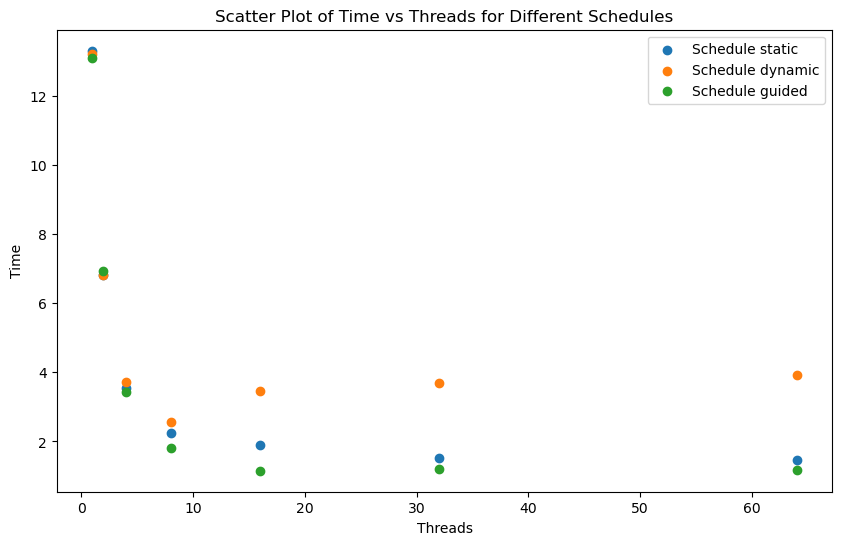

In [8]:
data = df[(df['size'] == 10**9) & (df['chunk'] == 4096)]

schedule_0 = data[data['schedule'] == 'static']
schedule_1 = data[data['schedule'] == 'dynamic']
schedule_2 = data[data['schedule'] == 'guided']

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(schedule_0['threads'], schedule_0['time'], label='Schedule static')
plt.scatter(schedule_1['threads'], schedule_1['time'], label='Schedule dynamic')
plt.scatter(schedule_2['threads'], schedule_2['time'], label='Schedule guided')

# Set plot labels and title
plt.xlabel('Threads')
plt.ylabel('Time')
plt.title('Scatter Plot of Time vs Threads for Different Schedules')
plt.legend()

# Show plot
plt.show()

In [9]:
# here we select the type/chunk/threads trio with the fastest times
prefiltered = df[df.chunk > 0] # remove automatic selection
min_idx = prefiltered.groupby(["schedule", "chunk", "threads"]).mean()[['time']].groupby(["schedule"]).idxmin()
min_idx = min_idx.reset_index(drop=True)
min_idx[["schedule", "chunk", "threads"]] = pd.DataFrame(min_idx['time'].tolist(), index=min_idx.index)
min_idx = min_idx[["schedule", "chunk", "threads"]]
min_idx

,schedule,chunk,threads
0,dynamic,4096,8
1,guided,2048,16
2,static,1024,32


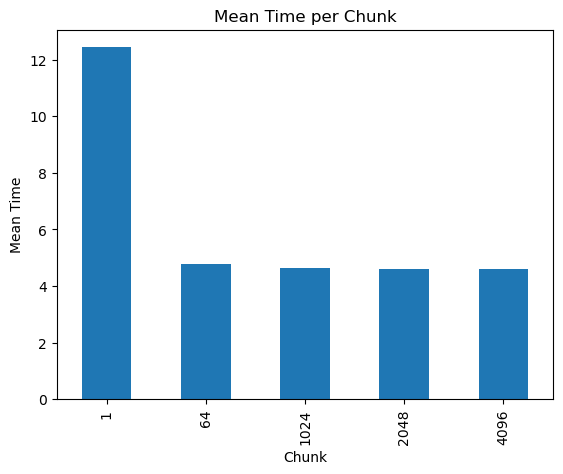

In [10]:
filtered_df = df[df['size'] == 10**9]

mean_time_per_chunk = filtered_df.groupby('chunk')['time'].mean()

mean_time_per_chunk.plot(kind='bar')
plt.xlabel('Chunk')
plt.ylabel('Mean Time')
plt.title('Mean Time per Chunk')
plt.show()

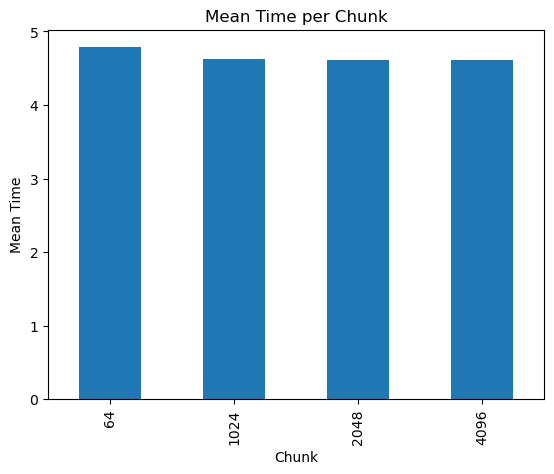

In [11]:
filtered_df = df[(df['size'] == 10**9) & (df['chunk'] != 1)]
mean_time_per_chunk = filtered_df.groupby('chunk')['time'].mean()
mean_time_per_chunk.plot(kind='bar')

plt.xlabel('Chunk')
plt.ylabel('Mean Time')
plt.title('Mean Time per Chunk')
plt.show()

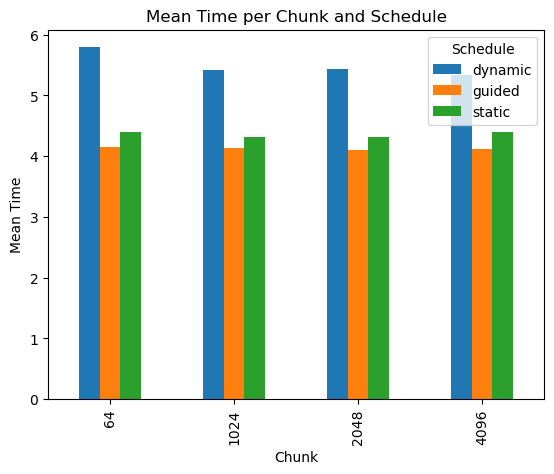

In [12]:
filtered_df = df[(df['size'] == 10**9) & (df['chunk'] != 1)]
mean_time_per_chunk_schedule = filtered_df.groupby(['schedule', 'chunk'])['time'].mean()
mean_time_per_chunk_schedule_unstacked = mean_time_per_chunk_schedule.unstack(level=0)
mean_time_per_chunk_schedule_unstacked.plot(kind='bar')

plt.xlabel('Chunk')
plt.ylabel('Mean Time')
plt.title('Mean Time per Chunk and Schedule')
plt.legend(title='Schedule')
plt.show()

In [13]:
def compare_chunk_size_for_one_schedule(data, size, schedule):
    chunk_1 = data[data['chunk'] == 1].sort_values(by='threads')
    chunk_64 = data[data['chunk'] == 64].sort_values(by='threads')
    chunk_1024 = data[data['chunk'] == 1024].sort_values(by='threads')
    chunk_2048 = data[data['chunk'] == 2048].sort_values(by='threads')
    chunk_4096 = data[data['chunk'] == 4096].sort_values(by='threads')
    
    plt.figure(figsize=(10, 6))
    plt.scatter(chunk_1['threads'], chunk_1['time'], label='Chunk Size: 1')
    plt.scatter(chunk_64['threads'], chunk_64['time'], label='Chunk Size: 64')
    plt.scatter(chunk_1024['threads'], chunk_1024['time'], label='Chunk Size: 1024')
    plt.scatter(chunk_2048['threads'], chunk_2048['time'], label='Chunk Size: 2048')
    plt.scatter(chunk_4096['threads'], chunk_4096['time'], label='Chunk Size: 4096')
    
    plt.plot(chunk_1['threads'], chunk_1['time'], linestyle='-', color='blue', alpha=0.5)
    plt.plot(chunk_64['threads'], chunk_64['time'], linestyle='-', color='orange', alpha=0.5)
    plt.plot(chunk_1024['threads'], chunk_1024['time'], linestyle='-', color='green', alpha=0.5)
    plt.plot(chunk_2048['threads'], chunk_2048['time'], linestyle='-', color='red', alpha=0.5)
    plt.plot(chunk_4096['threads'], chunk_4096['time'], linestyle='-', color='purple', alpha=0.5)
    
    plt.xlabel('Threads')
    plt.ylabel('Time')
    title = "Size: " + size + " Schedule: " + schedule
    plt.title(title)
    plt.legend()
    
    plt.show()

## Scatter Plot of Time vs Threads for Different Chunk Sizes

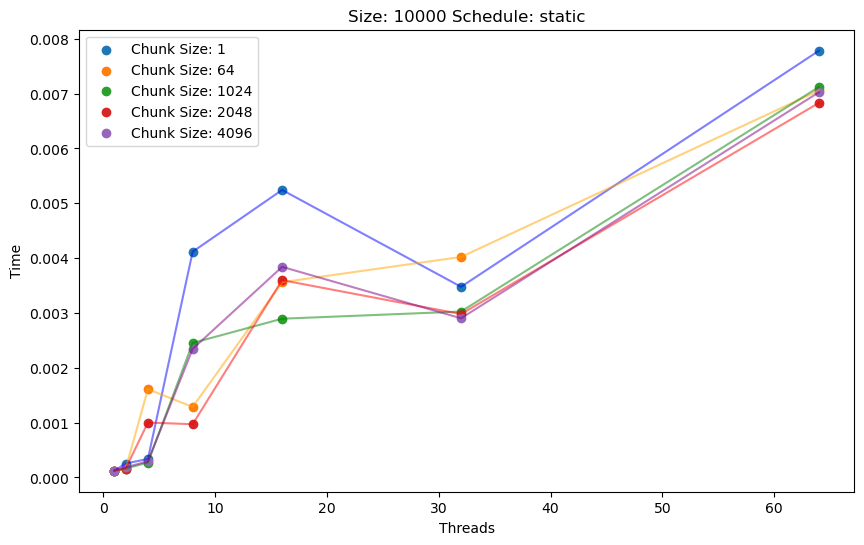

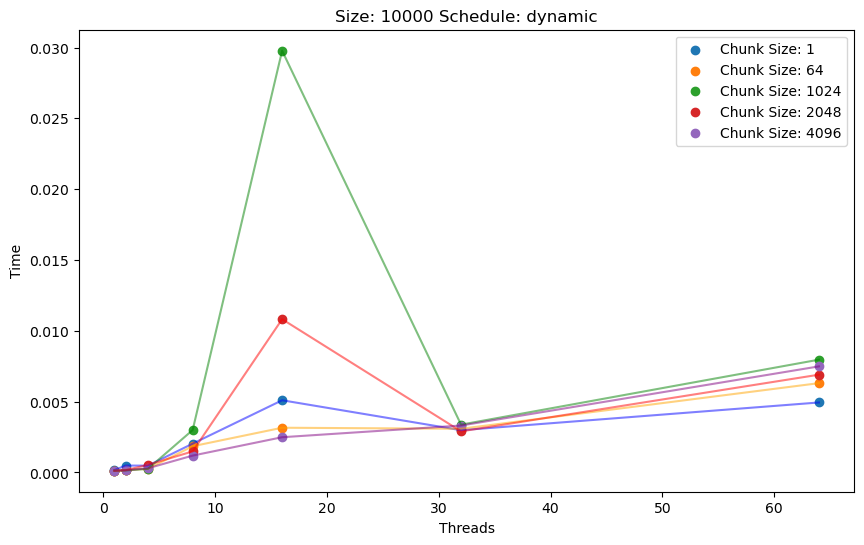

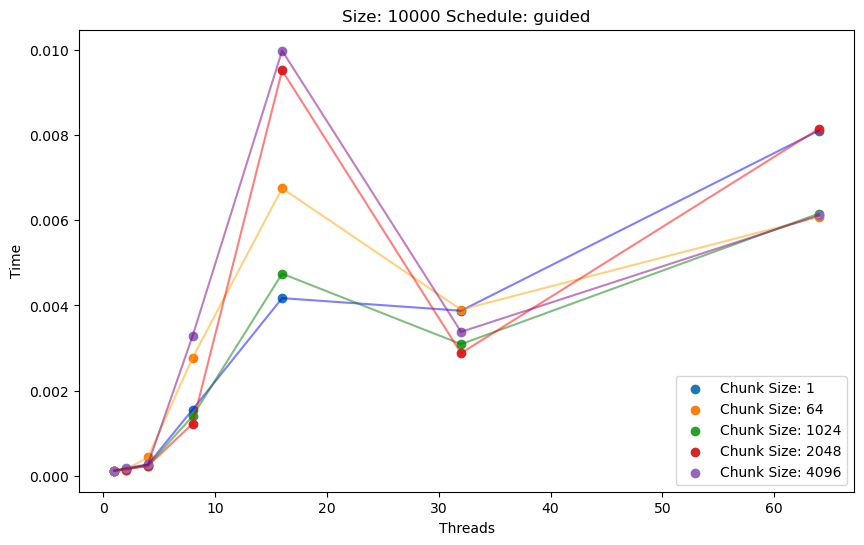

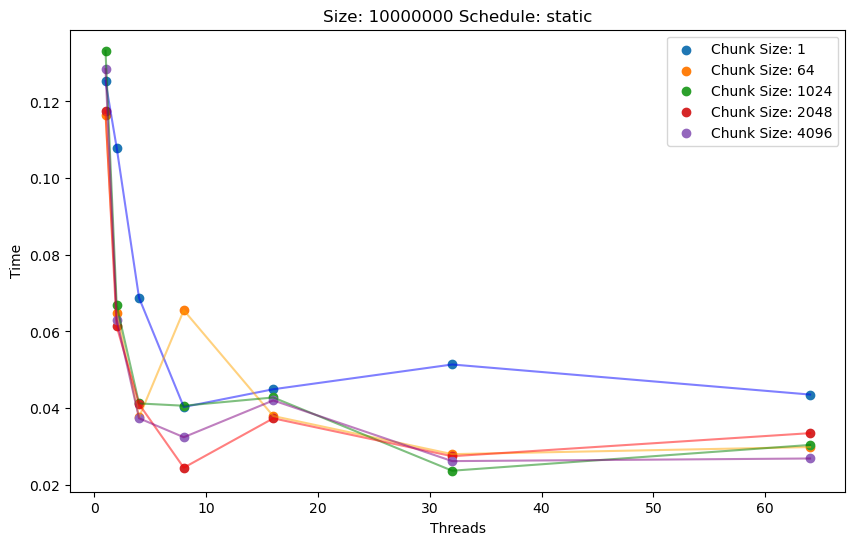

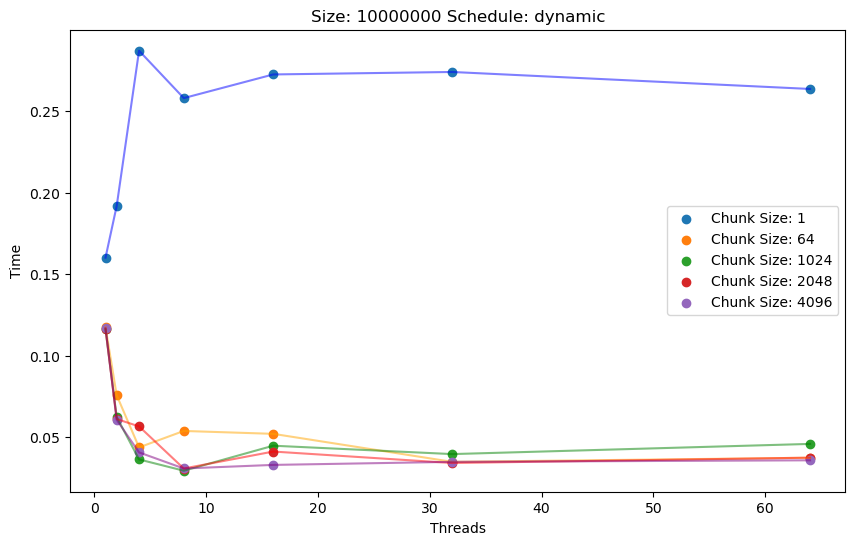

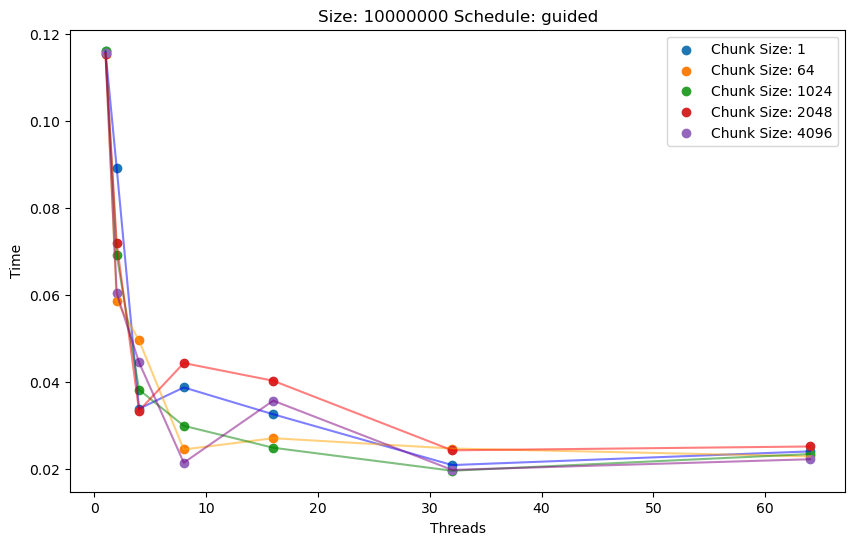

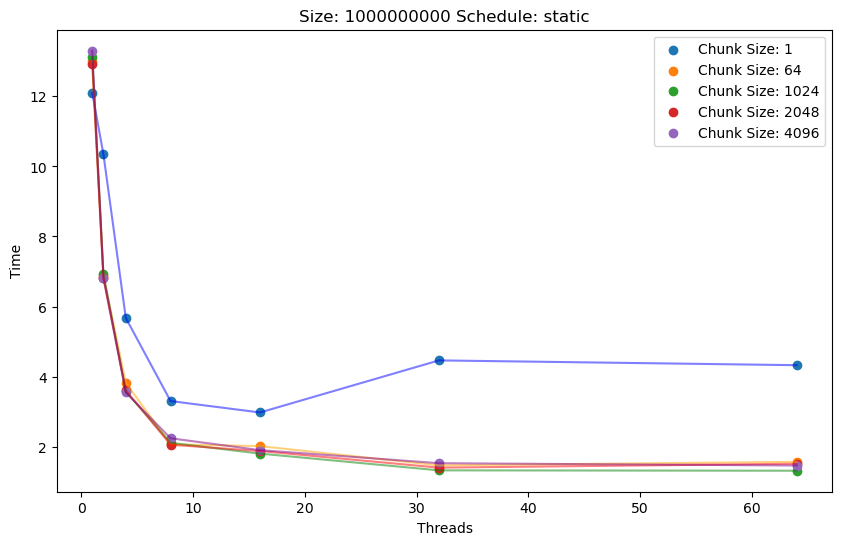

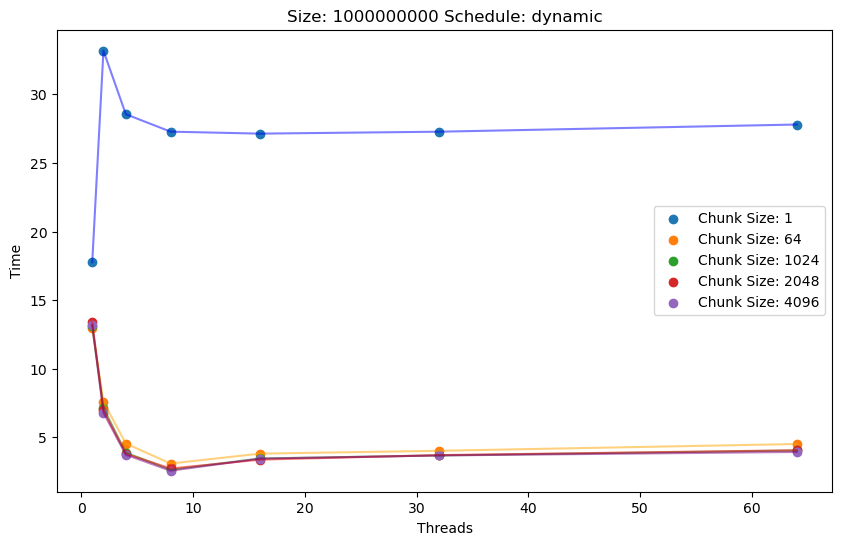

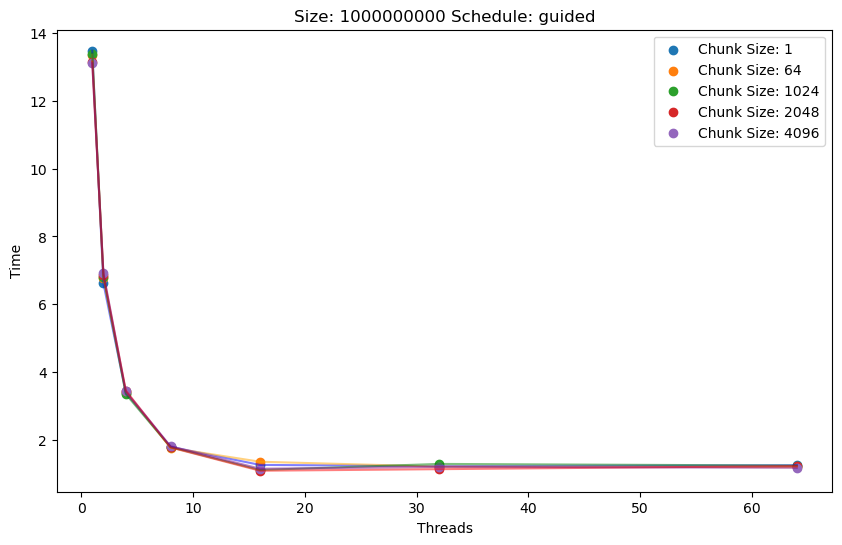

In [14]:
for size in [10**4, 10**7, 10**9]:
    for schedule in ['static', 'dynamic', 'guided']:
        compare_chunk_size_for_one_schedule(df[(df['size'] == size) & (df['schedule'] == schedule)], str(size), schedule)

### Fastest Runs for each size for each schedule

In [15]:
fastest_indices = df.groupby(['size', 'schedule'])['time'].idxmin()
fastest_runs = df.loc[fastest_indices]

print(fastest_runs)

           size schedule  chunk  threads      time
49        10000  dynamic   1024        1  0.000124
84        10000   guided   1024        1  0.000123
0         10000   static      1        1  0.000123
157    10000000  dynamic   1024        8  0.029348
194    10000000   guided   1024       32  0.019503
124    10000000   static   1024       32  0.023691
276  1000000000  dynamic   4096        8  2.565099
305  1000000000   guided   2048       16  1.092803
230  1000000000   static   1024       64  1.313981


In [16]:
fastest_runs.reset_index(drop=True, inplace=True)
fastest_runs['rank'] = fastest_runs.groupby('size')['time'].rank(method='min')
fastest_runs_sorted = fastest_runs.sort_values(by='time')
print(fastest_runs_sorted)

         size schedule  chunk  threads      time  rank
1       10000   guided   1024        1  0.000123   1.0
2       10000   static      1        1  0.000123   1.0
0       10000  dynamic   1024        1  0.000124   3.0
4    10000000   guided   1024       32  0.019503   1.0
5    10000000   static   1024       32  0.023691   2.0
3    10000000  dynamic   1024        8  0.029348   3.0
7  1000000000   guided   2048       16  1.092803   1.0
8  1000000000   static   1024       64  1.313981   2.0
6  1000000000  dynamic   4096        8  2.565099   3.0


### Mean Time vs. Threads for Different Schedules

In [17]:
def plot_mean_time_vs_threads_for_each_schedule(size):

    filtered_df = df[df['size'] == size]
    grouped_df = filtered_df.groupby(['threads', 'schedule']).mean().reset_index()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for schedule, data in grouped_df.groupby('schedule'):
        ax.plot(data['threads'], data['time'], marker='o', label=f'Schedule {schedule}')
    
    ax.set_xlabel('Threads')
    ax.set_ylabel('Time')
    ax.set_title("Size: " + str(size))
    ax.legend()
    
    plt.grid(True)
    plt.show()

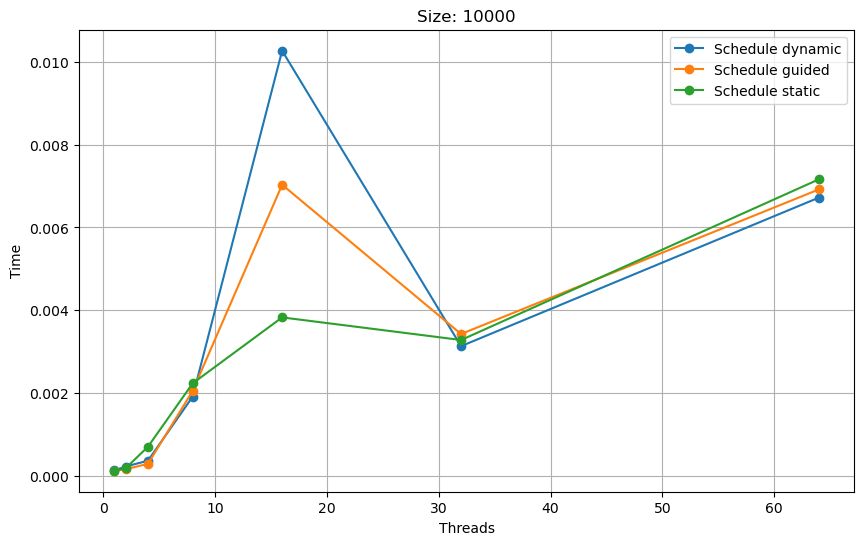

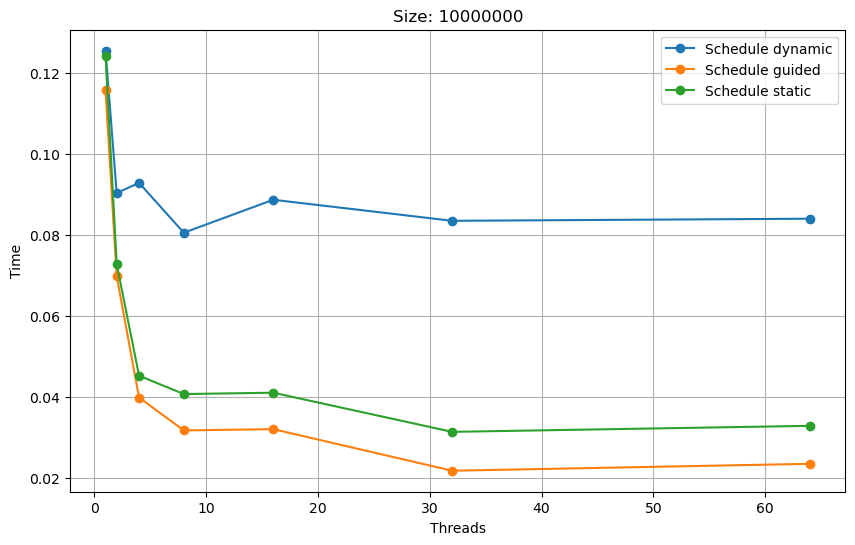

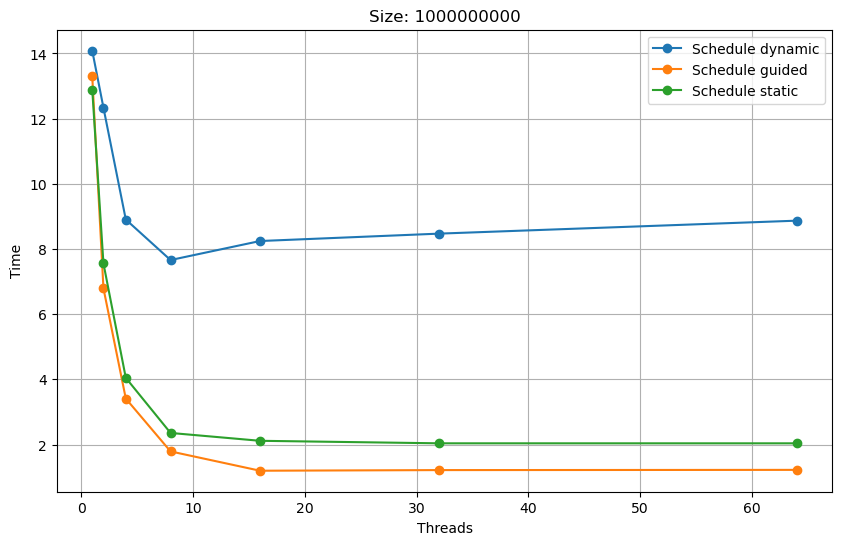

In [18]:
for size in [10**4, 10**7, 10**9]:
    plot_mean_time_vs_threads_for_each_schedule(size)

### Speedup vs Threads for Different Schedules and Chunk Sizes

In [49]:
# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

def plot_speedup_vs_threads(size, chunk):
    filtered_df = df[(df['size'] == size) & (df['chunk'] == chunk)]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for schedule in filtered_df['schedule'].unique():
        data = filtered_df[filtered_df['schedule'] == schedule]
        base_time = data['time'][data['threads'] == 1].values[0]
        data['speedup'] = base_time / data['time']
        ax.plot(data['threads'], data['speedup'], marker='o', label=f'Schedule {schedule}')

        # plot y=x
        ax.plot(data['threads'], data['threads'], linestyle='--', color='black', alpha=0.5)
    
    
    ax.set_xlabel('Threads')
    ax.set_ylabel('Speedup')
    ax.set_title("Size: " + str(size) + " | Chunk: " + str(chunk))
    ax.legend()
    
    plt.grid(True)
    plt.show()

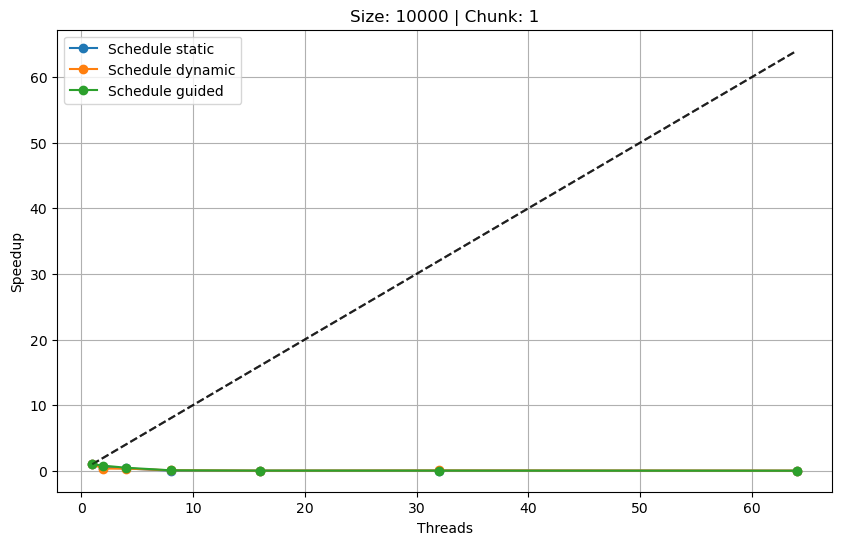

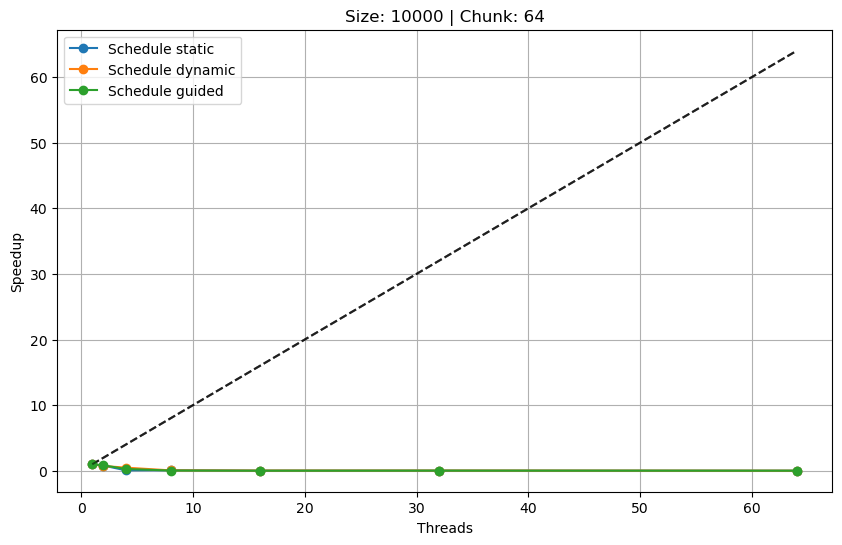

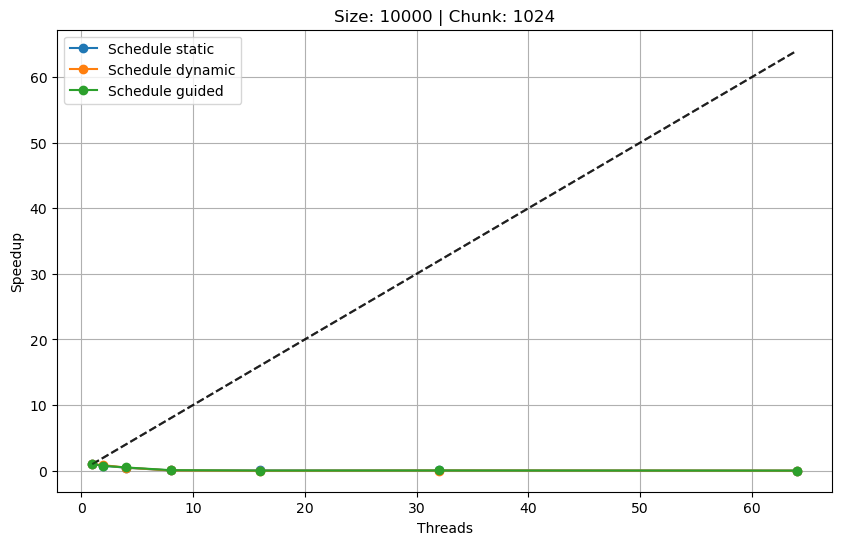

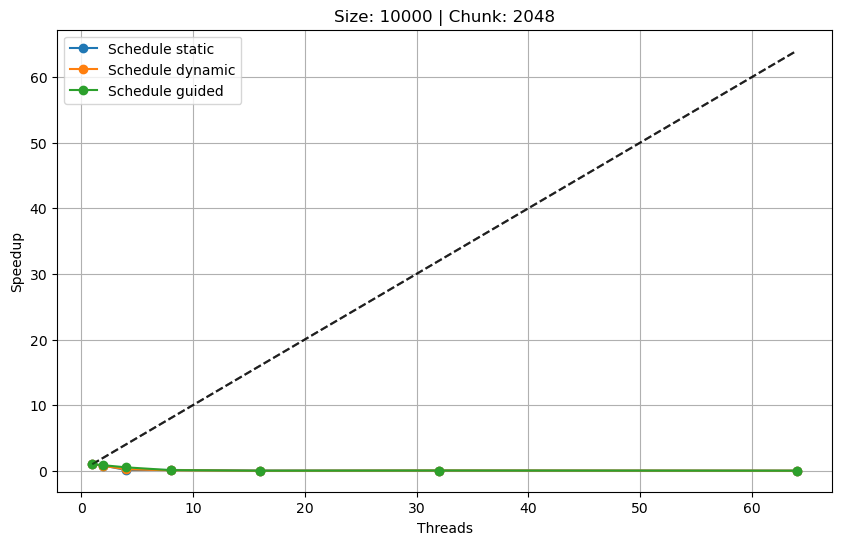

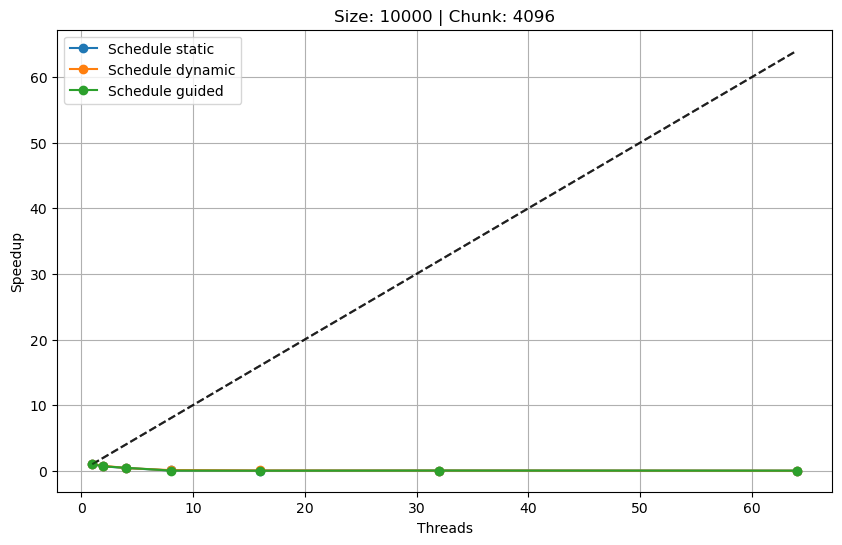

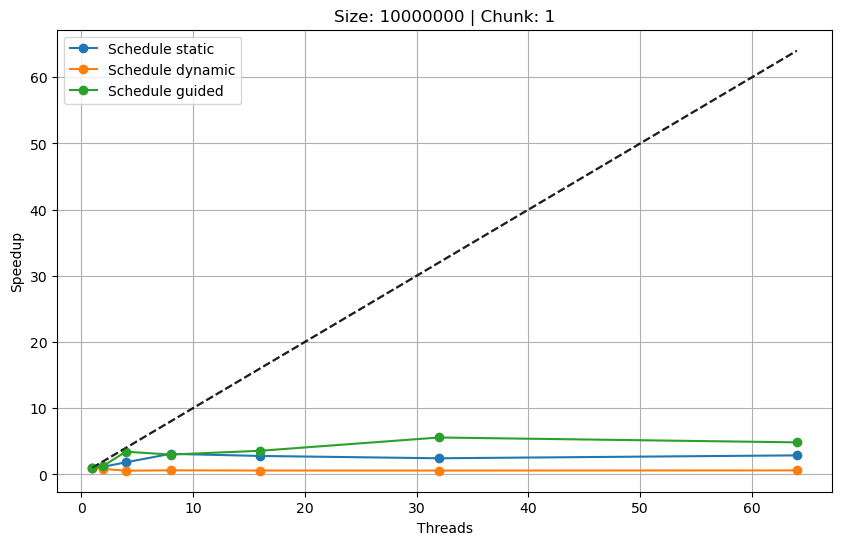

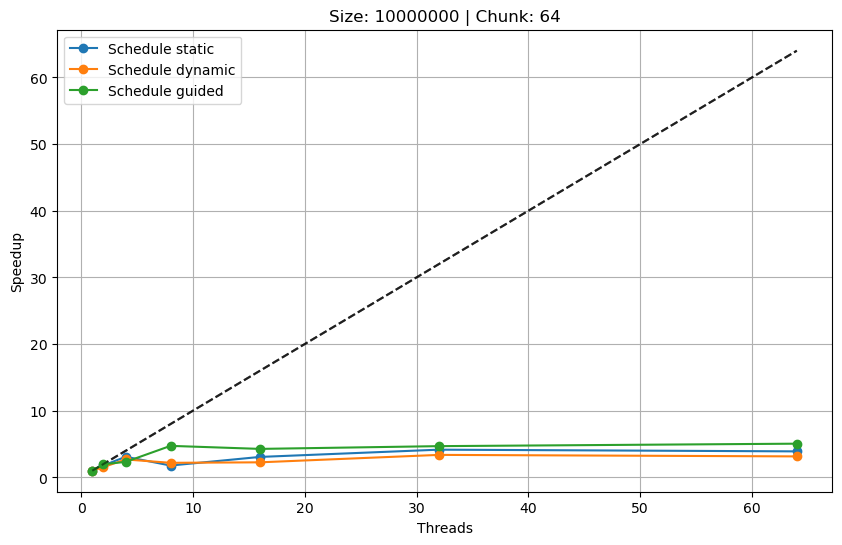

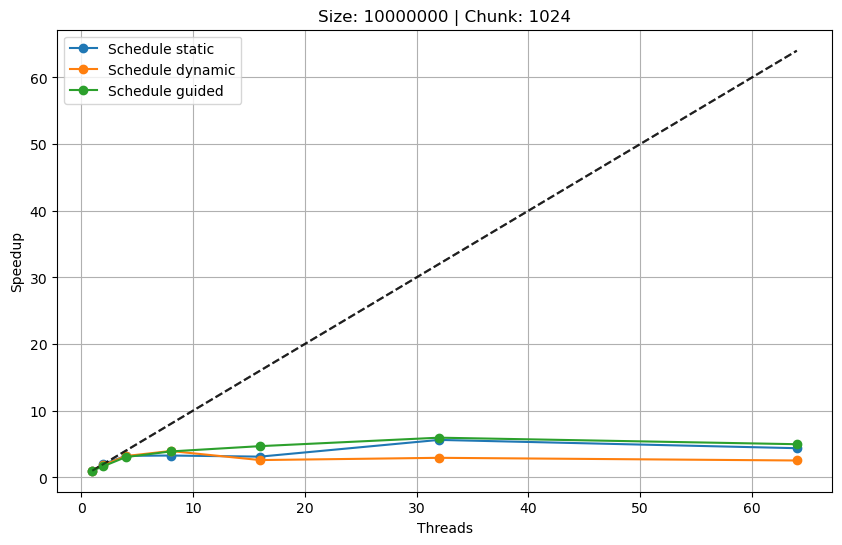

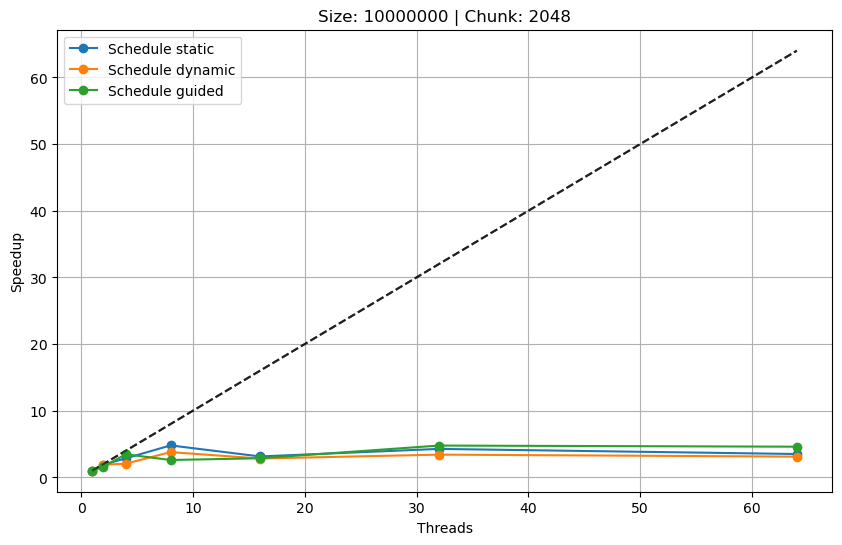

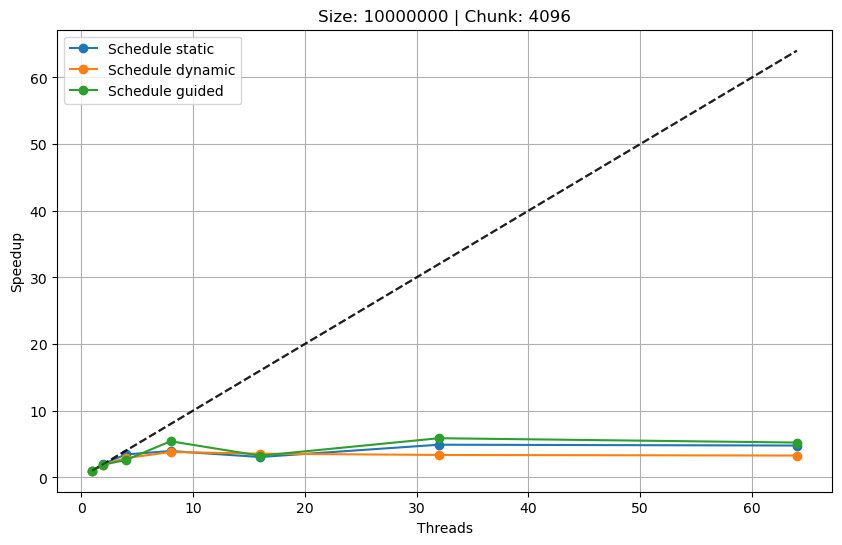

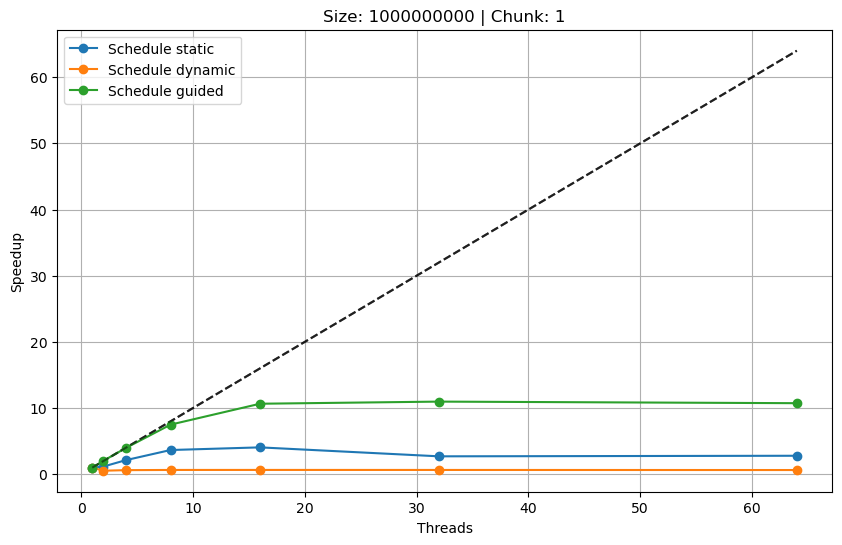

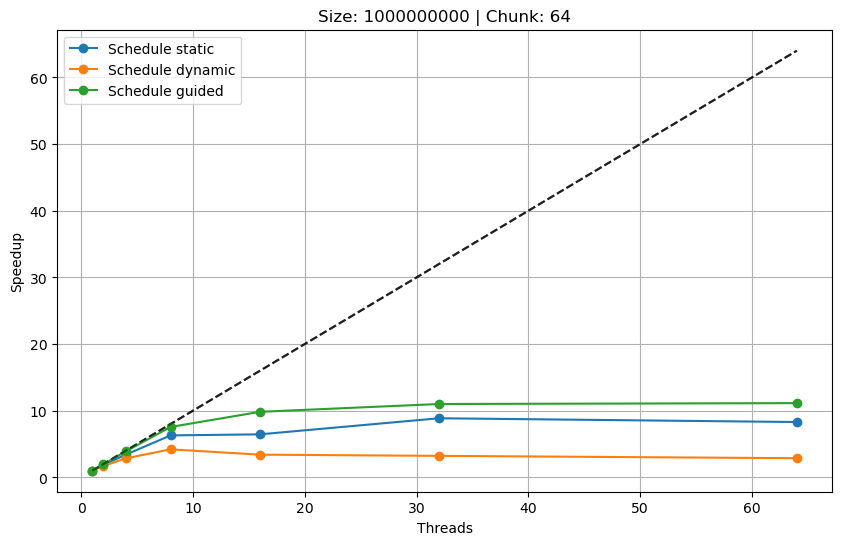

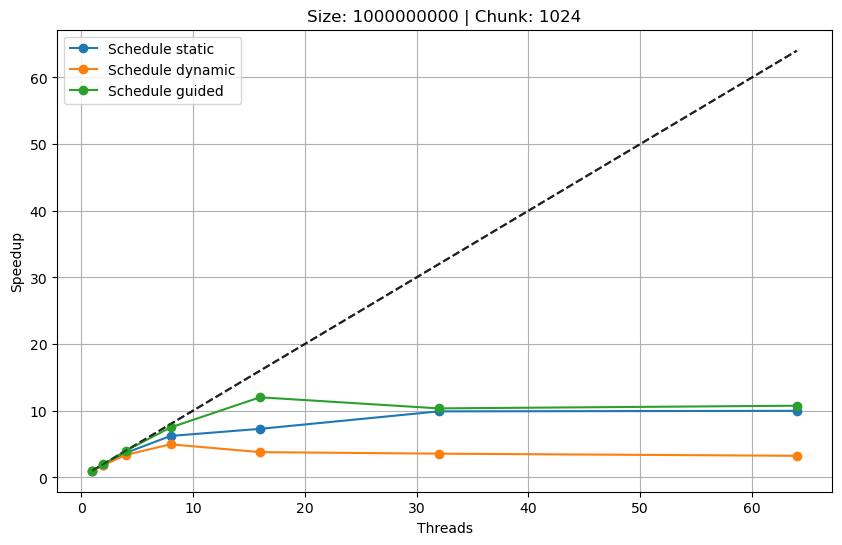

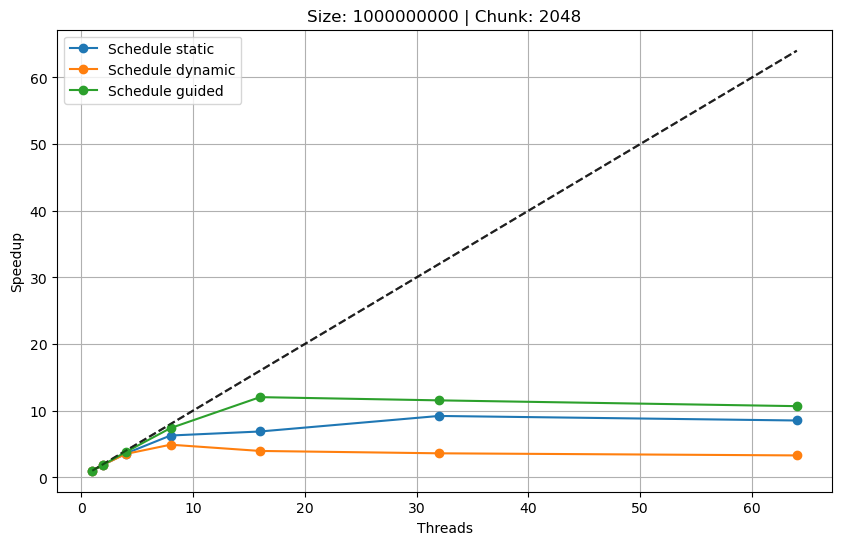

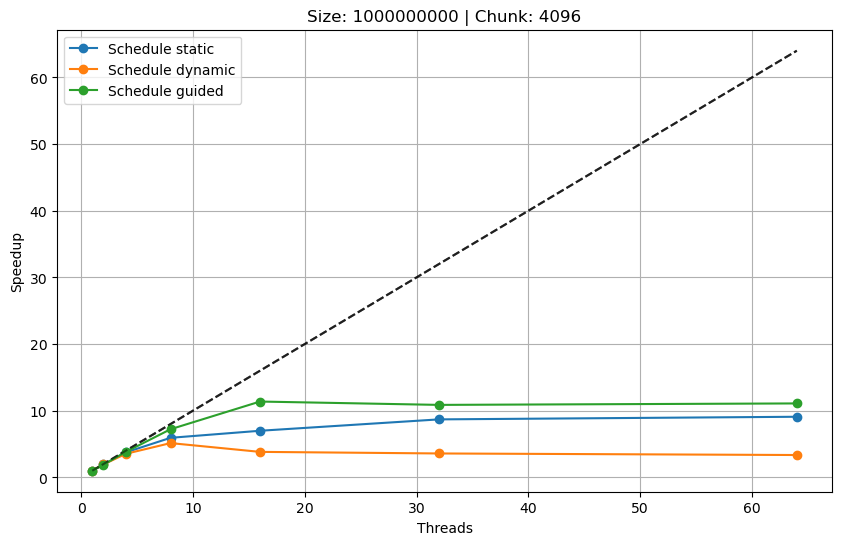

In [50]:
for size in [10**4, 10**7, 10**9]:
    for chunk in [1, 64, 1024, 2048, 4096]:
        plot_speedup_vs_threads(size, chunk)

### Efficiency vs Threads for Different Schedules and Chunk Sizes

In [53]:
def plot_efficiency_vs_threads(size, chunk):
    filtered_df = df[(df['size'] == size) & (df['chunk'] == chunk)]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for schedule in filtered_df['schedule'].unique():
        data = filtered_df[filtered_df['schedule'] == schedule]
        base_time = data['time'][data['threads'] == 1].values[0]
        data['efficiency'] = base_time / (data['threads'] * data['time'])
        ax.plot(data['threads'], data['efficiency'], marker='o', label=f'Schedule {schedule}')

        # plot y=1
        ax.plot(data['threads'], [1] * len(data['threads']), linestyle='--', color='black', alpha=0.5)

    
    ax.set_xlabel('Threads')
    ax.set_ylabel('Efficiency')
    ax.set_title("Size: " + str(size) + " | Chunk: " + str(chunk))
    ax.legend()
    
    plt.grid(True)
    plt.show()

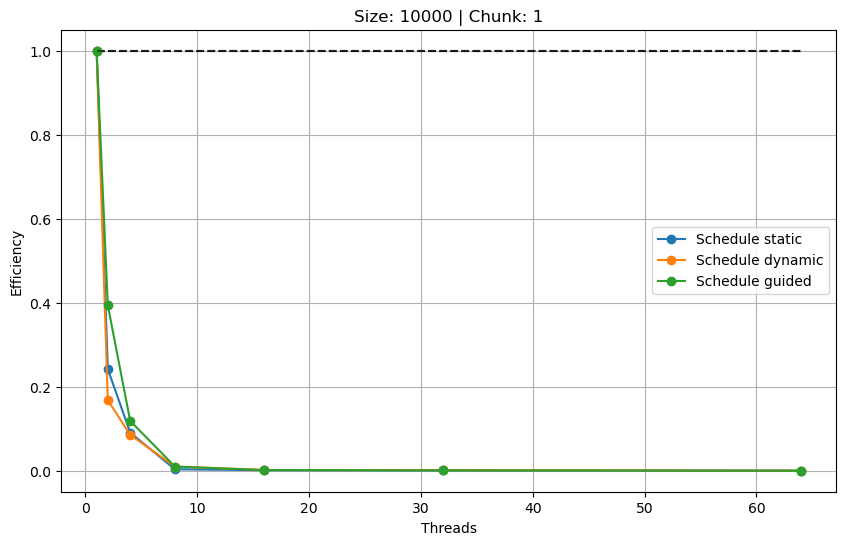

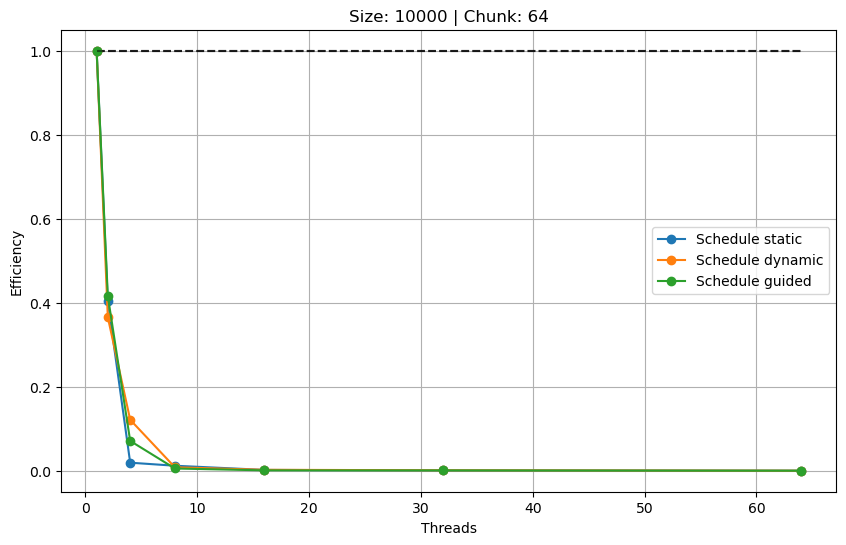

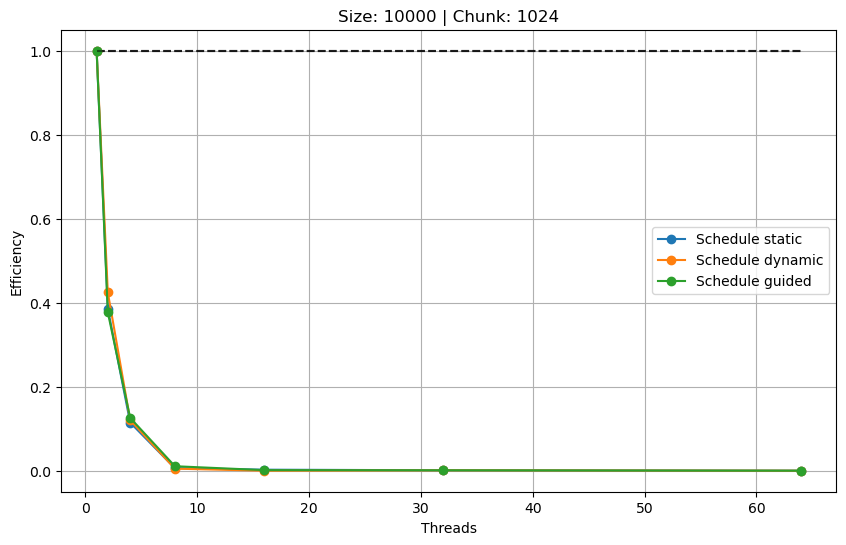

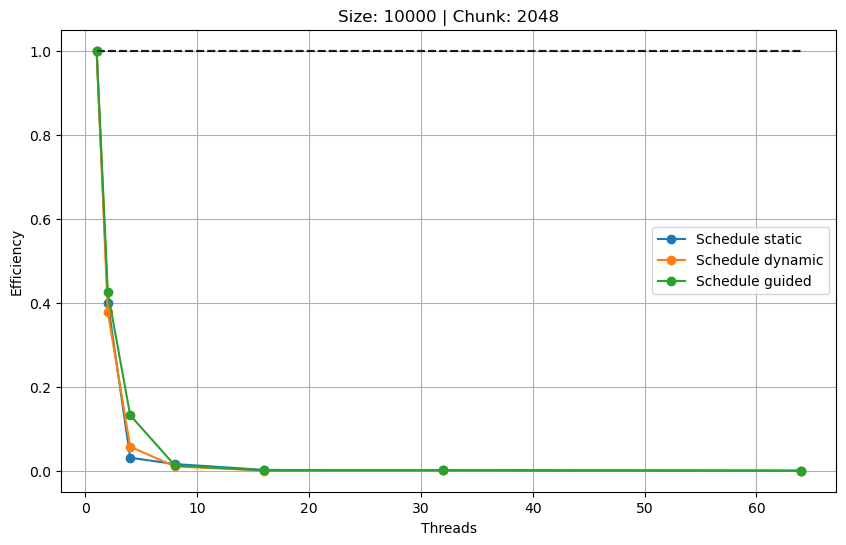

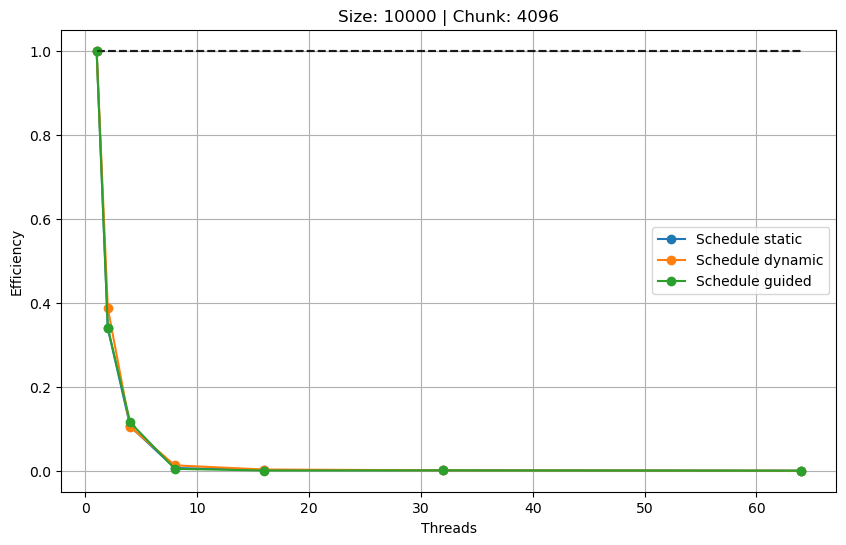

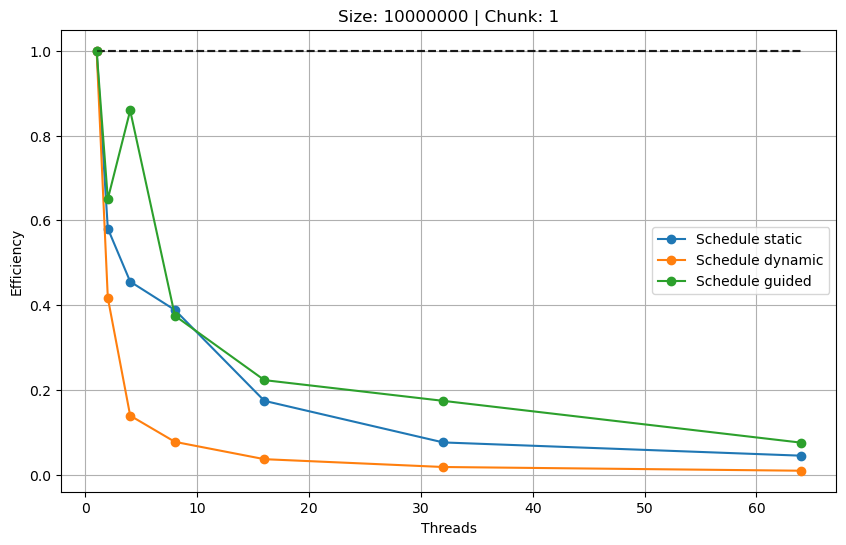

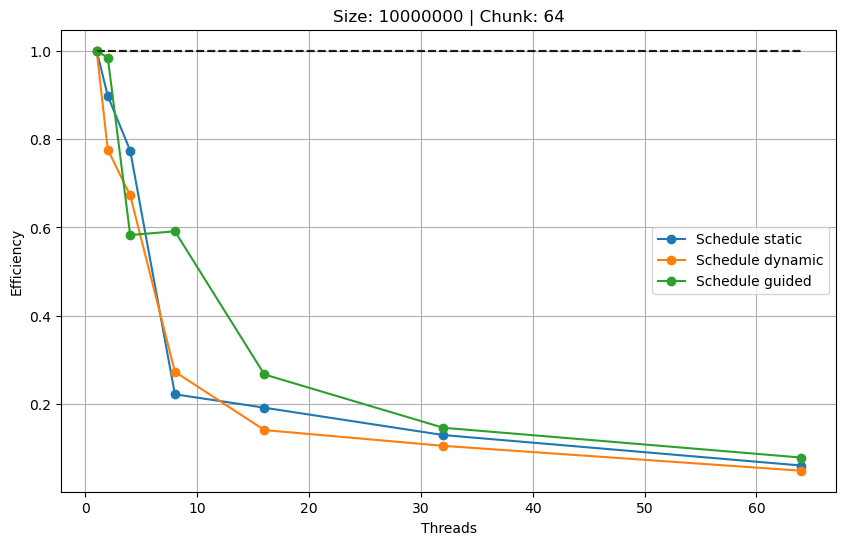

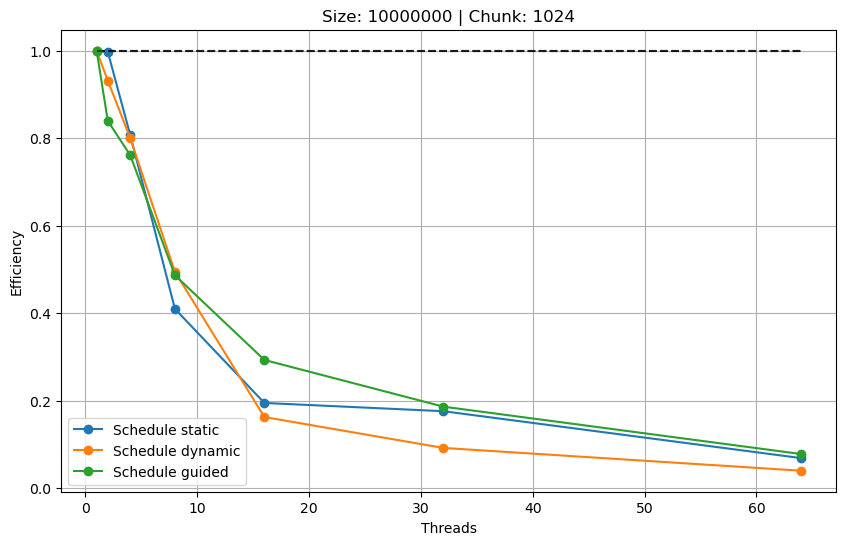

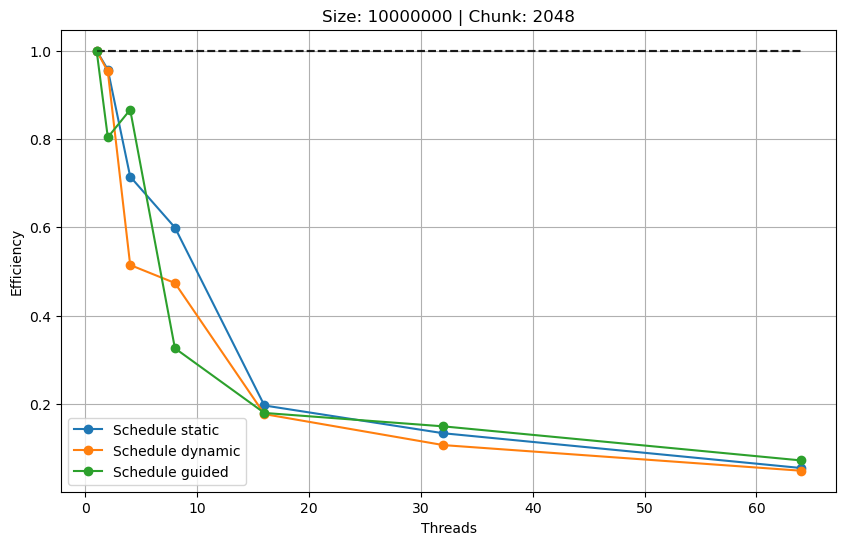

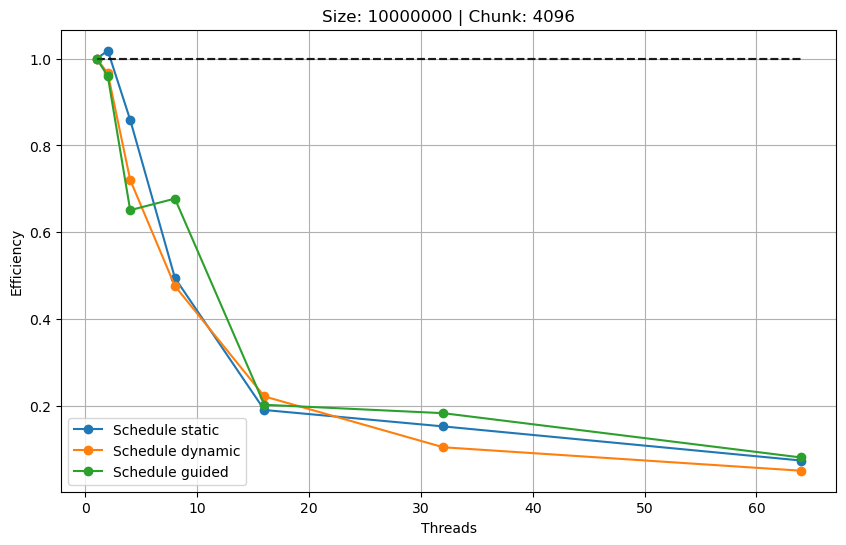

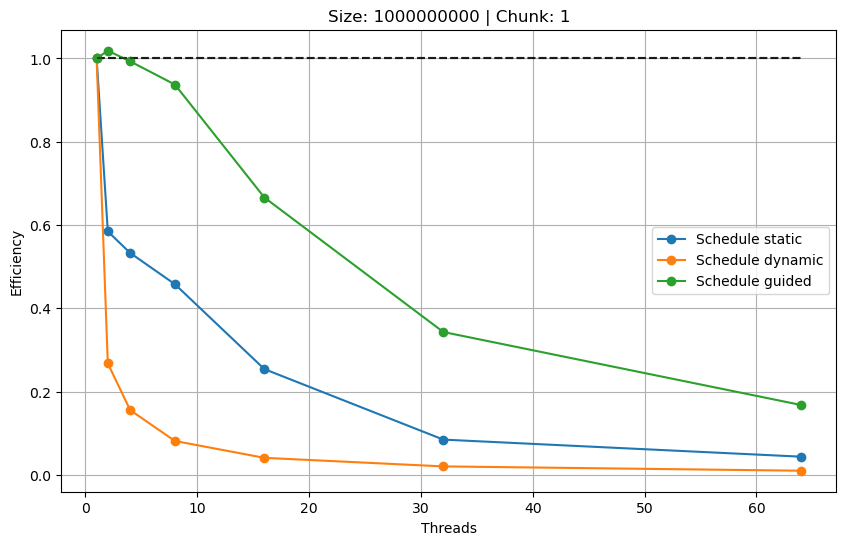

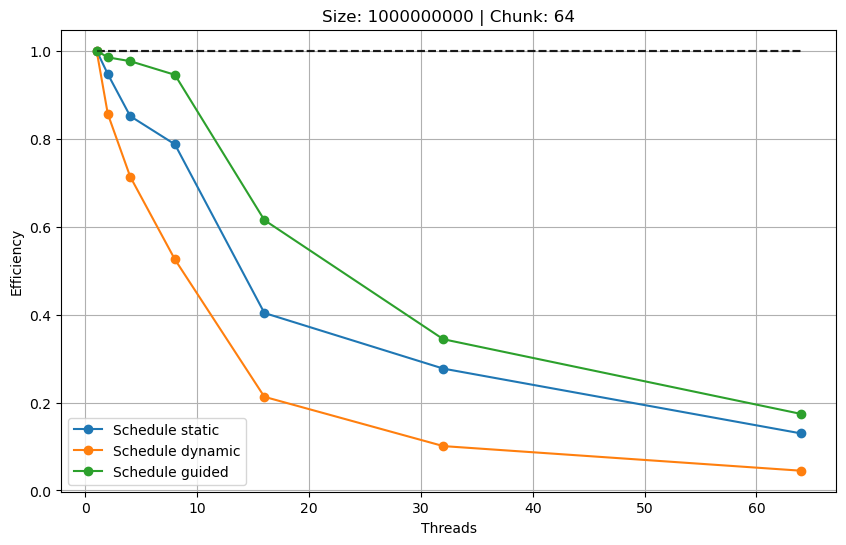

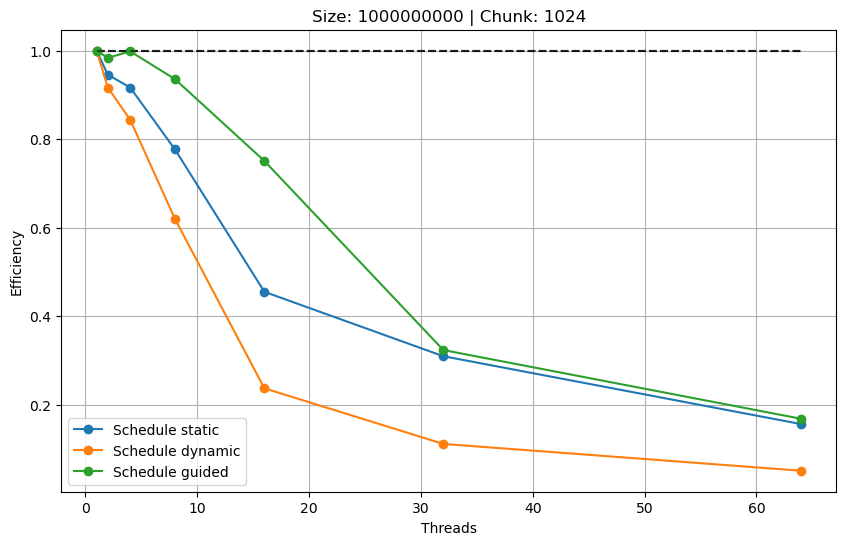

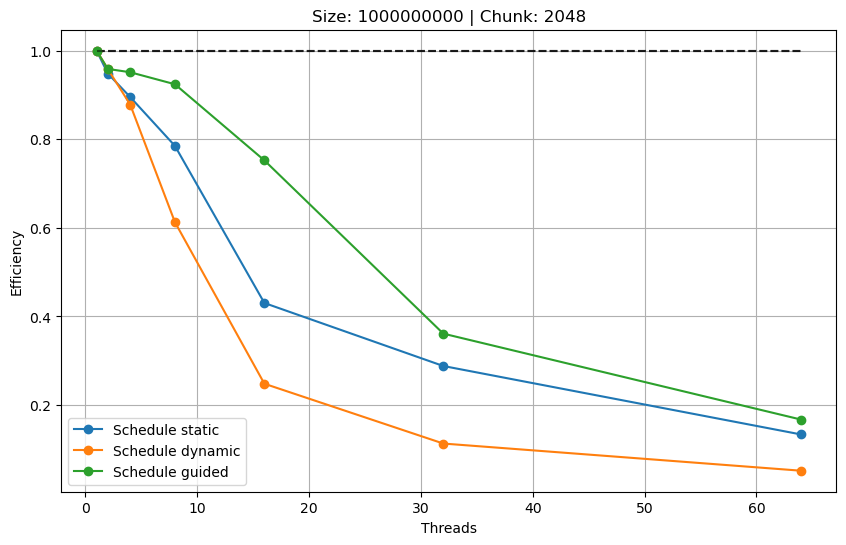

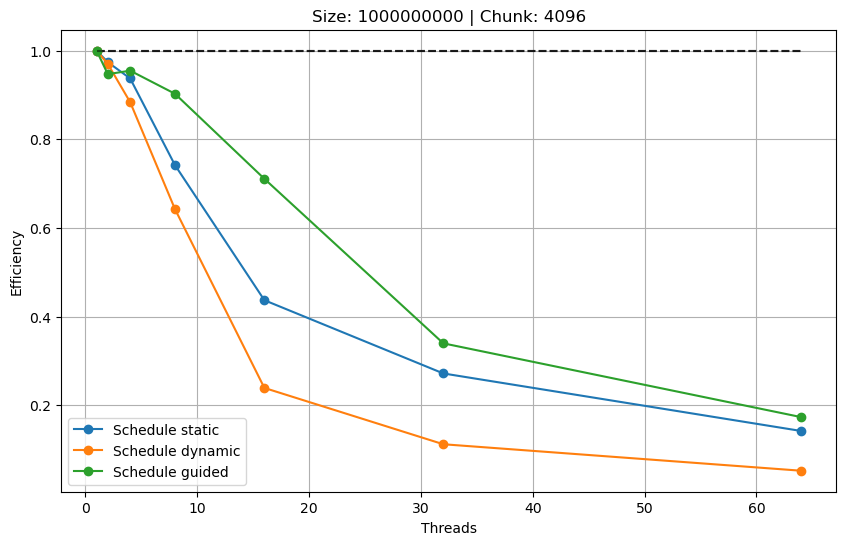

In [54]:
for size in [10**4, 10**7, 10**9]:
    for chunk in [1, 64, 1024, 2048, 4096]:
        plot_efficiency_vs_threads(size, chunk)

### Wnioski

Mały chunk size powoduje, że jest za duży overhead na wyznaczanie chunków dla konkretnych procesów.
Stosowanie większej wartości szybciej rozkłada obliczenia na wątki, co powoduje, że czas wykonania jest krótszy.

Tryb guided dla odpowiedniej minimalnej wartości chunka bardzo dobrze działa dla tego problemu. Rozkład obliczeń na wątki
jest bardzo równomierny i rozmiar chunka nie zmaleje do bardzo małej wartości, która ja wspomniano wcześniej daje
słabe wyniki.

Tryb static daje trochę słabsze wyniki od guided, jednak stosuje stałą wartość chunka size.

Dynamic jako, że stosuje na bazie "first come, first served" daje najgorsze wyniki, gdyż niektóre procesy mogą
otrzymać znacznie większe przedziały do obliczeń w stosunku do innych trybów.